<h1 style="text-align: center;">Hotel booking cancellation prediction</h1>

## 1. Project overview

This is the final project for DTSA 5509 (Supervised Learning). I would like to perform exploratory data analysis (EDA) on a hotel booking demand dataset and use supervised learning methods to predict whether or not a hotel booking was likely to be canceled in the future.

The dataset is originally from [Hotel Booking Demand Datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191#t0005), and it can be downloaded from [Kaggle](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data). The data was extracted from hotels’ Property Management System (PMS) SQL databases, containing hotel booking information in Portugal from July 1, 2015 to August 31, 2017.

### Objective
In this project, I am going to train a Decision Tree Classifier model, and evaluate how well it predicts later cancellations based on all the information available at the time of booking. Also using this Decision Tree Classifier model as a baseline, I would compare several ensemble and boosting methods to see which one performs better on this dataset.

## 2. Exploratory Data Analysis (EDA) 

### Data inspection

This dataset includes 118898 samples and 32 variables. To train the predictive model, I select the "is_canceled" column as the label column, the the other 31 columns as features. These columns are defined below.

| Column | Description |
| :----------- | :----------- |
| hotel | H1 = Resort Hotel or H2 = City Hotel |
| is_canceled | The booking was canceled (1) or not (0) | 
| lead_time | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date |
| arrival_date_year | Year of arrival date |
| arrival_date_month | Month of arrival date |
| arrival_date_week_number | Week number of year for arrival date |
| arrival_date_day_of_month | Day of arrival date |
| stays_in_weekend_nights | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
| stays_in_week_nights | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel |
| adults | Number of adults |
| children | Number of children |
| babies | Number of babies |
| meal | Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner) |
| country | Country of origin |
| market_segment | In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| distribution_channel | The term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| is_repeated_guest |  a repeated guest (1) or not (0) |
| previous_cancellations | Number of previous bookings that were cancelled by the customer prior to the current booking |
| previous_bookings_not_canceled | Number of previous bookings not cancelled by the customer prior to the current booking |
| reserved_room_type | Code of room type reserved. Code is presented instead of designation for anonymity reasons |
| assigned_room_type | Code for the type of room assigned to the booking.|
| booking_changes | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| deposit_type | No Deposit; Non Refund; Refundable. |
| agent | ID of the travel agency that made the booking |
| company | ID of the company/entity that made the booking or responsible for paying the booking.  |
| days_in_waiting_list | Number of days the booking was in the waiting list before it was confirmed to the customer |
| customer_type | Contract: when the booking has an allotment or other type of contract associated to it; Group: when the booking is associated to a group; Transient: when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party: when the booking is transient, but is associated to at least other transient booking |
| adr | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
| required_car_parking_spaces | Number of car parking spaces required by the customer |
| total_of_special_requests | Number of special requests made by the customer (e.g. twin bed or high floor) |
| reservation_status | Canceled: booking was canceled by the customer; Check-Out: customer has checked in but already departed; No-Show: customer did not check-in and did inform the hotel of the reason why |
| reservation_status_date | Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel |

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/hotel_bookings.csv')

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Data Cleaning

#### Drop features

Through inspecting the data, the "market_segment" and "distribution_channel" have duplicate or confusing values. And "agent" and "company" features are not meaningful. In addition, the features "is_canceled" and "arrival_date*" already provide enough information, and we do not need repeated supplementary information for "reservation_status" and "reservation_status_date". So we drop these columns.

In [4]:
df = df.drop(columns=['market_segment','distribution_channel','agent','company',
                      'reservation_status','reservation_status_date'])
df = df.dropna()

#### Convert all object datatype to categorical

For correlation analysis, all features should have a datatype of int or float. Therefore we need to convert all features with object datatype to categorical numbers.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118898 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118898 non-null  object 
 1   is_canceled                     118898 non-null  int64  
 2   lead_time                       118898 non-null  int64  
 3   arrival_date_year               118898 non-null  int64  
 4   arrival_date_month              118898 non-null  object 
 5   arrival_date_week_number        118898 non-null  int64  
 6   arrival_date_day_of_month       118898 non-null  int64  
 7   stays_in_weekend_nights         118898 non-null  int64  
 8   stays_in_week_nights            118898 non-null  int64  
 9   adults                          118898 non-null  int64  
 10  children                        118898 non-null  float64
 11  babies                          118898 non-null  int64  
 12  meal                 

In [6]:
# Convert "arrival_date_month" datatype to numbers
d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 
     'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
df.arrival_date_month = df.arrival_date_month.map(d)

# Convert all object type columns to categorical
for col_name in df.columns:
    if(df[col_name].dtype == 'object'):
        df[col_name]= df[col_name].astype('category')
        df[col_name] = df[col_name].cat.codes

In [7]:
# Move column "is_canceled" to the first column
first_column = df.pop('is_canceled') 
df.insert(0, 'is_canceled', first_column) 
display(df)

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,1,342,2015,7,27,1,0,0,2,...,0,2,2,3,0,0,2,0.00,0,0
1,0,1,737,2015,7,27,1,0,0,2,...,0,2,2,4,0,0,2,0.00,0,0
2,0,1,7,2015,7,27,1,0,1,1,...,0,0,2,0,0,0,2,75.00,0,0
3,0,1,13,2015,7,27,1,0,1,1,...,0,0,0,0,0,0,2,75.00,0,0
4,0,1,14,2015,7,27,1,0,2,2,...,0,0,0,0,0,0,2,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,0,23,2017,8,35,30,2,5,2,...,0,0,0,0,0,0,2,96.14,0,0
119386,0,0,102,2017,8,35,31,2,5,3,...,0,4,4,0,0,0,2,225.43,0,2
119387,0,0,34,2017,8,35,31,2,5,2,...,0,3,3,0,0,0,2,157.71,0,4
119388,0,0,109,2017,8,35,31,2,5,2,...,0,0,0,0,0,0,2,104.40,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118898 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118898 non-null  int64  
 1   hotel                           118898 non-null  int8   
 2   lead_time                       118898 non-null  int64  
 3   arrival_date_year               118898 non-null  int64  
 4   arrival_date_month              118898 non-null  int64  
 5   arrival_date_week_number        118898 non-null  int64  
 6   arrival_date_day_of_month       118898 non-null  int64  
 7   stays_in_weekend_nights         118898 non-null  int64  
 8   stays_in_week_nights            118898 non-null  int64  
 9   adults                          118898 non-null  int64  
 10  children                        118898 non-null  float64
 11  babies                          118898 non-null  int64  
 12  meal                 

### Data Visualization

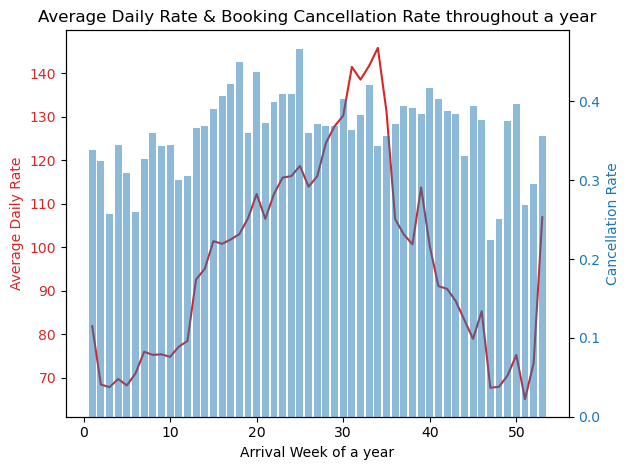

In [9]:
fig, ax1 = plt.subplots()
ax1.set_title("Average Daily Rate & Booking Cancellation Rate throughout a year")

color = 'tab:red'
ax1.set_xlabel('Arrival Week of a year')
ax1.set_ylabel('Average Daily Rate', color=color)
ax1.plot(df.groupby(['arrival_date_week_number']).agg({'adr':['mean']}), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df1 = df.groupby(['arrival_date_week_number']).agg({'is_canceled': ['count', 'sum']})
df1["cancellation_rate"] = df1[("is_canceled","sum")]/df1[("is_canceled", "count")]
df1.drop([("is_canceled","sum"), ("is_canceled", "count")], axis=1)

color = 'tab:blue'
ax2.set_ylabel('Cancellation Rate', color=color) 
ax2.bar(df1.index, df1["cancellation_rate"], color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

As can be seen from the figure, the highest daily rates throughout a year are concentrated in the summer (around weeks 27 to 35).However, the cancellation rates in summer declined slightly compared to adjacent periods. This makes sense since more difficulty and more expensive in booking a hotel room would result in higher cancellation costs.

#### Use heat map to visualize the correlation matrix

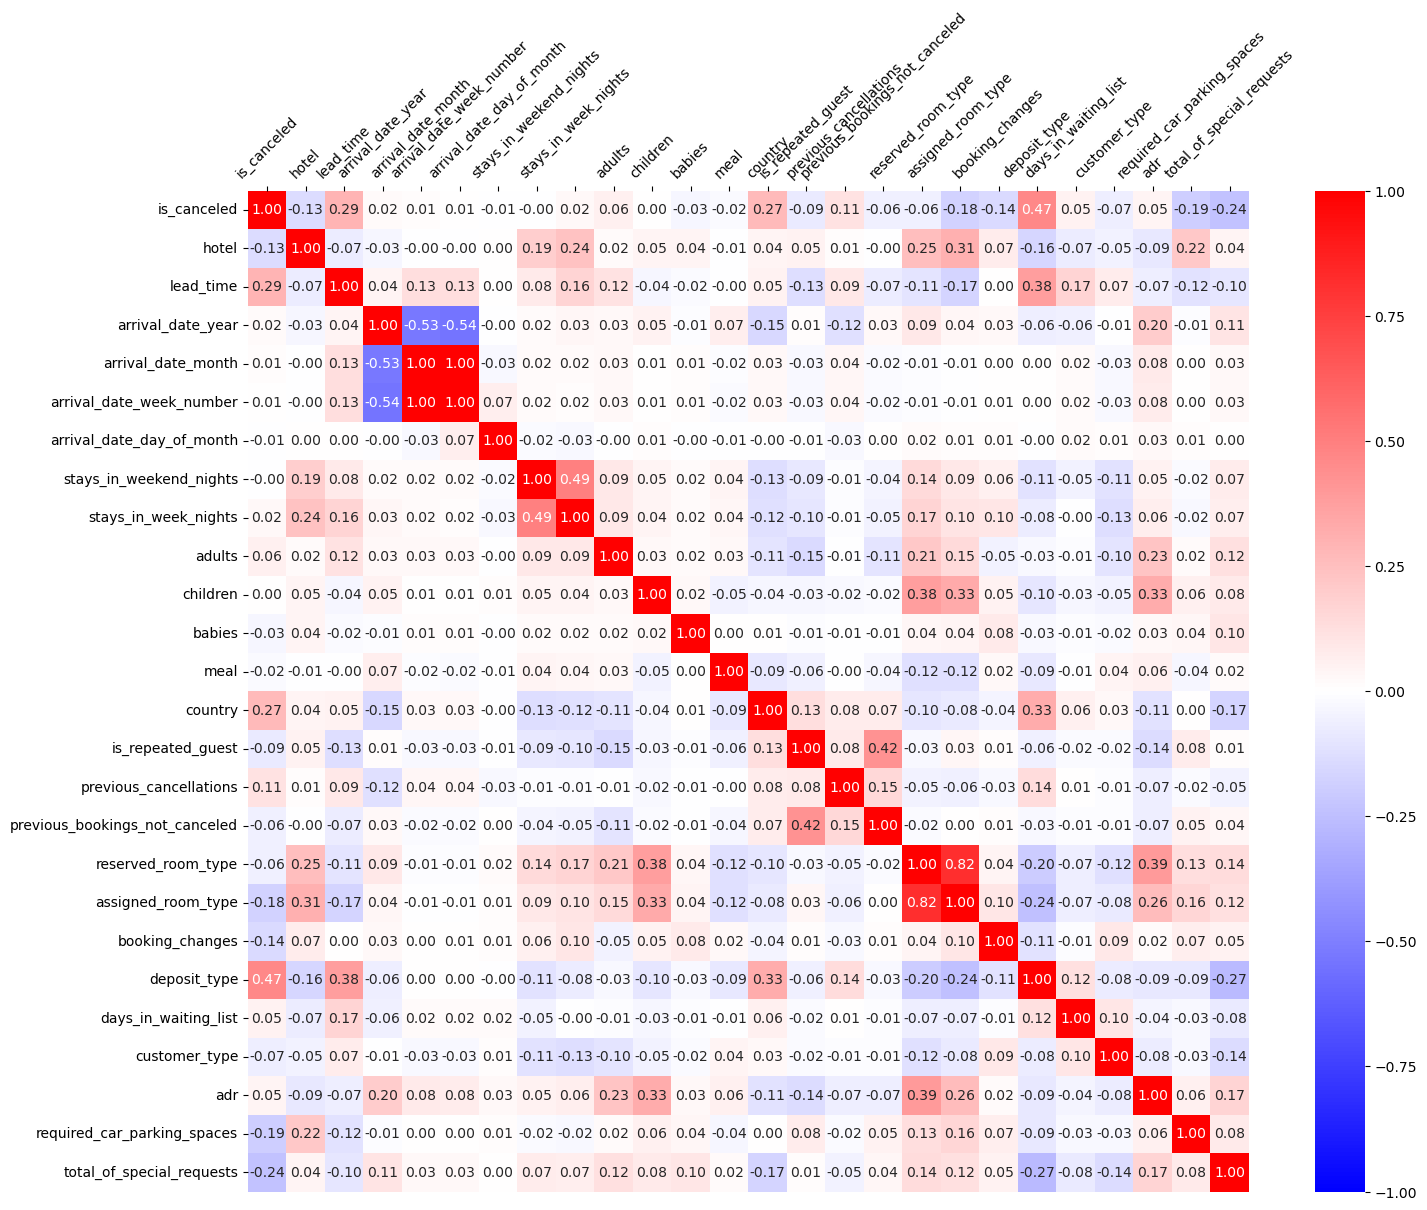

In [10]:
hm = sns.heatmap(data=df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='bwr', square=True, yticklabels=1)
hm.figure.set_size_inches(17, 13)
hm.xaxis.tick_top()
plt.xticks(rotation=45)
plt.savefig("correlation_heatmap.png")

From the correlation matrix, we can see that these features are not collinear, and feature "deposit_type" is most correlated with "is_canceled" label. Since the values for "deposit_type" include "No Deposit", "Non Refund" and "Refundable", it makes sense that if a reservation does not require a deposit or the deposit is refundable, cancellation is more likely to happen.

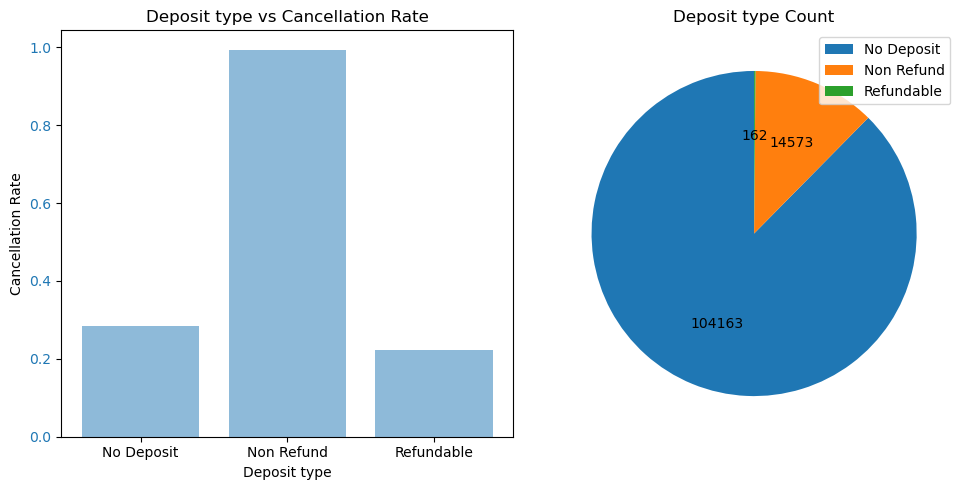

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10, 5))
ax[0].set_title("Deposit type vs Cancellation Rate")
ax[0].set_xlabel('Deposit type')
ax[0].set_ylabel('Cancellation Rate') # color='tab:blue'
df1 = df.groupby(['deposit_type']).agg({'is_canceled': ['count', 'sum']})
df1["cancellation_rate"] = df1[("is_canceled","sum")]/df1[("is_canceled", "count")]
ax[0].bar(df1.index, df1["cancellation_rate"], color=color, alpha=0.5)
ax[0].tick_params(axis='y', labelcolor=color)
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(["No Deposit", "Non Refund", "Refundable"])

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{absolute:d}"
  
ax[1].set_title("Deposit type Count")
wedges, texts, autotexts = ax[1].pie(df1[("is_canceled", "count")], 
          autopct=lambda pct: func(pct, df1[("is_canceled", "count")]), startangle=90)
ax[1].legend(wedges, ["No Deposit", "Non Refund", "Refundable"],
          loc="best",
          )

fig.tight_layout()
plt.show()

These visualizations show that the "Non refund" deposit type has the highest cancellation rate, while the most common deposit type, "No Deposit", has a much lower cancellation rate.

## 3. Modeling

### Data preparation

While deposit type has the highest correlation with cancellation, cancellation situations are more complex and require more features to be considered.

In order to develop a model with higher prediction accuracy for the likelihood of booking cancellation, I split the data into train and test datasets, so that 80% of the randomly selected samples will be used to train the model, and the remaining 20% of the data will be retained for testing model accuracy.

In [12]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

### Decision Tree Classifier

First I will build a Decision Tree Classifier. To prevent overfitting, I want to develop a complete tree and then post-prun it using the hyperparameter "ccp_alpha". So the following is an exploration to find the best value of ccp_alpha.

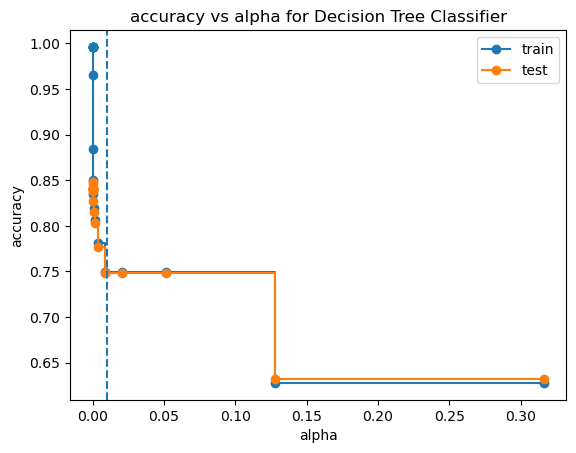

In [13]:
DecisionTreeclf = DecisionTreeClassifier().fit(X_train, y_train)

# Explore the best value of ccp_alpha in post pruning
ccp_alphas= list(np.logspace(-8,-0.5,20))

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = []
test_scores = []
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs alpha for Decision Tree Classifier")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.axvline(x=0.01, ls="--")
ax.legend()
plt.show() 

From the plot, I set parameter ccp_alpha=0.01 in DecisionTreeClassifier to train the model, and then visualize the final tree, and plot the ROC curve to see how well the model does.

In [14]:
DecisionTreeclf = DecisionTreeClassifier(ccp_alpha=0.01).fit(X_train, y_train)

print("Decision Tree Accuracy:", DecisionTreeclf.score(X_test, y_test))

Decision Tree Accuracy: 0.7480656013456686


[Text(0.6, 0.9, 'x[19] <= 0.5\ngini = 0.467\nsamples = 95118\nvalue = [59708, 35410]'),
 Text(0.4, 0.7, 'x[1] <= 14.5\ngini = 0.407\nsamples = 83227\nvalue = [59535, 23692]'),
 Text(0.2, 0.5, 'gini = 0.215\nsamples = 20831\nvalue = [18277, 2554]'),
 Text(0.6, 0.5, 'x[12] <= 134.5\ngini = 0.448\nsamples = 62396\nvalue = [41258, 21138]'),
 Text(0.4, 0.3, 'x[21] <= 2.5\ngini = 0.387\nsamples = 41806\nvalue = [30833, 10973]'),
 Text(0.2, 0.1, 'gini = 0.436\nsamples = 33022\nvalue = [22437, 10585]'),
 Text(0.6, 0.1, 'gini = 0.084\nsamples = 8784\nvalue = [8396, 388]'),
 Text(0.8, 0.3, 'gini = 0.5\nsamples = 20590\nvalue = [10425, 10165]'),
 Text(0.8, 0.7, 'gini = 0.029\nsamples = 11891\nvalue = [173, 11718]')]

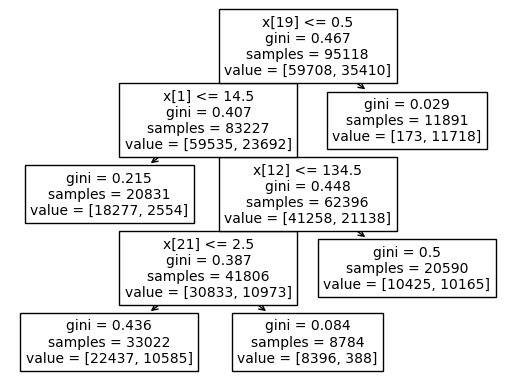

In [15]:
# Visualize the tree
tree.plot_tree(DecisionTreeclf.fit(X_train, y_train))

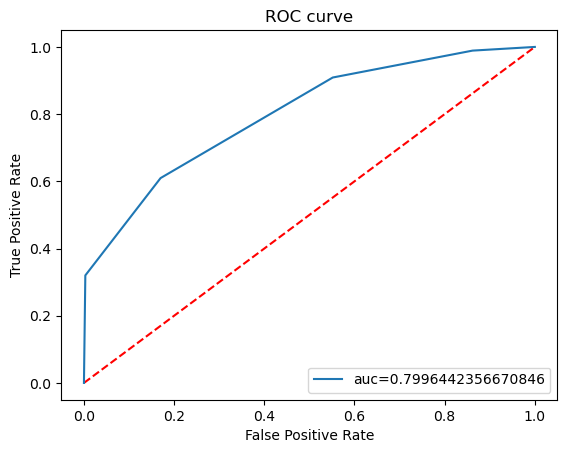

In [16]:
# Plot the ROC curve ( True positive rate vs False positive rate) 

y_pred_proba = DecisionTreeclf.predict_proba(X_test)[:,1]

fpr, tpr, th = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'r--')

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The ROC curve shows that the Decision Tree Classifier performs well (test accuracy 75%, AUC 80%). Yet this is not good enough. I wanted to explore several Ensemble methods to see if the accuracy could be significantly improved.

GridSearchCV is a great way to optimize parameter selection via cross-validated grid-search. I will apply GridSearchCV in the emsemble models to find the optimal hyperparameters.

### Adaboost Classifier

In [17]:
Adaclf = AdaBoostClassifier(n_estimators=150, algorithm="SAMME").fit(X_train, y_train)
print("Adaboost Accuracy:", Adaclf.score(X_test, y_test))

Adaboost Accuracy: 0.804793944491169


### Gradient Boosting Classifer

In [18]:
from sklearn.model_selection import GridSearchCV

In [25]:
grid_GB = GridSearchCV(estimator = GradientBoostingClassifier(),
                       param_grid = {'max_features': ['sqrt', 'log2', 0.8, None],
                                     'max_depth': [3,5,10,30,None],
                                     'ccp_alpha': [0, 0.01, 0.05, 0.1],
                                    },
                       scoring = 'accuracy',
                       cv = 5,
                       n_jobs = -1
                      )
grid_GB.fit(X_train,y_train)
print ("Gradient Boosting best parameters: ", grid_GB.best_params_)
print ("Gradient Boosting Accuracy:", grid_GB.best_score_)

Gradient Boosting best parameters:  {'ccp_alpha': 0, 'max_depth': None, 'max_features': 'sqrt'}
Gradient Boosting Accuracy: 0.8804852842473412


### Random Forest Classifier

In [26]:
grid_RF = GridSearchCV(estimator = RandomForestClassifier(),
                       param_grid = {'max_features': ['sqrt', 'log2', 0.8, None],
                                     'max_depth': [3,5,10,30,None],
                                     'ccp_alpha': [0, 0.01, 0.05, 0.1],
                                    },
                       scoring = 'accuracy',
                       cv = 5,
                       n_jobs = -1
                      )
grid_RF.fit(X_train,y_train)
print ("Random Forest best parameters: ", grid_RF.best_params_)
print ("Random Forest Accuracy:", grid_RF.best_score_)

Random Forest best parameters:  {'ccp_alpha': 0, 'max_depth': 30, 'max_features': 'sqrt'}
Random Forest Accuracy: 0.8802119408858659


### Performance Comparison

In [27]:
n_trees = [10,20,50,100,200,500,1000]
DecisionTree_acc = []
Ada_acc = []
GB_acc = []
RF_acc = []

for i in n_trees:
  
  # Accuracy for Decision_Tree Classifier (baseline)
  DecisionTree_acc.append(DecisionTreeclf.score(X_test, y_test))

  # Accuracy for Adaboost Classfier
  Adaclf = AdaBoostClassifier(n_estimators=i, algorithm="SAMME").fit(X_train, y_train)
  Ada_acc.append(Adaclf.score(X_test, y_test))

  # Accuracy for Gradient Boosting Classifier
  GBclf = GradientBoostingClassifier(n_estimators=i, **grid_GB.best_params_).fit(X_train, y_train)
  GB_acc.append(GBclf.score(X_test, y_test))

  # Accuracy for Random Forest
  RFclf = RandomForestClassifier(n_estimators=i, **grid_RF.best_params_).fit(X_train, y_train)
  RF_acc.append(RFclf.score(X_test, y_test))

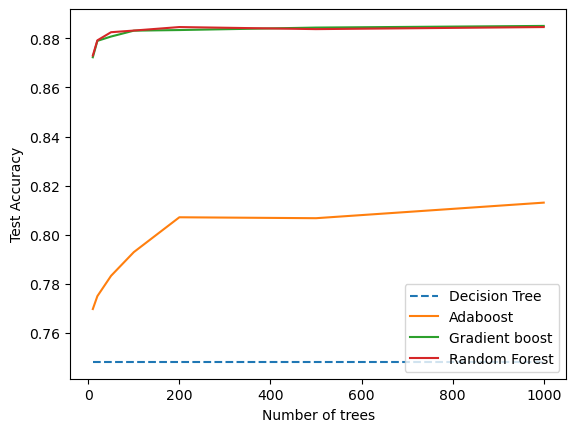

In [30]:
# Plot Accuracy for different Boosting Algorithm
plt.plot(n_trees, DecisionTree_acc, "--", label="Decision Tree")
plt.plot(n_trees, Ada_acc, label= "Adaboost")
plt.plot(n_trees, GB_acc, label= "Gradient boost")
plt.plot(n_trees, RF_acc, label = "Random Forest")
plt.xlabel("Number of trees")
plt.ylabel("Test Accuracy")
plt.legend(loc="best")
plt.show()

## 4. Discussion and Conclusion

In this project, my main goal is to train a predictive model to classify whether a hotel booking will be cancelled. During the EDA process, it can be seen that the highest average daily rate for a hotel booking occurs in summer, but the peak cancellation rate occurs before and after this time period. Furthermore most of the features appear to be uncorrelated or non-collinear with cancellation. But the machine learning models successfully predicted cancellations with relatively high accuracy.

First I developed a Decision Tree Classifier using post-pruning approach to prevent overfitting. The Decision Tree Classifier performed well with an average accuracy of 0.75 and an AUC of 0.80.

Then in order to make the tree stronger and further prevent overfitting, I also tried to apply several ensemble methods on the data, including Random Forest Classifier, Adaboost Classifier, and Gradient Boost Classifier. To optimize my ensemble models, I used GridSearchCV to find the best combination of hyperparameters for each emsemble classifier.

All three emsemble methods have better performance than Decision Tree Classifier. For this dataset with a small number of features (118897 samples, 25 features), Gradient Boost Classifier performs better than Adaboost Classifier. However there is no significant performance difference between Gradient Boost Classifier and Random Forest Classifier (test accuracy for both is around 88%), and the optimal "n_estimators" parameter is around 100 for both classifiers. 